# Import Libraries & dependencies

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, hstack
from sklearn.neighbors import NearestNeighbors

import json

import warnings
warnings.filterwarnings('ignore')

# Dataset loading

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
os.listdir(path)

Using Colab cache for faster access to the 'game-recommendations-on-steam' dataset.


['games_metadata.json', 'users.csv', 'games.csv', 'recommendations.csv']

In [ ]:
game_df = pd.read_csv(path + '/games.csv')
user_df = pd.read_csv(path + '/users.csv')
recommend_df = pd.read_csv(path + '/recommendations.csv')

In [ ]:
game_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [ ]:
user_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [ ]:
recommend_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [ ]:
games_metadata_df = pd.read_json(path + '/games_metadata.json', lines=True)
games_metadata_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [ ]:
dataframes = {
    'game_df' : game_df,
    'users_df' : user_df,
    'recommend_df' : recommend_df
}

# Checking null values
for name, df in dataframes.items():
    print(f"\nNull values in {name} :\n{df.isna().sum()}")

    # Dimension of dataframe
    df_dimension = df.shape

    print(f"Dimension of {name}: {df_dimension}")

# Number of unique ID values in each dataframe
n_games = game_df['app_id'].nunique()
n_users = user_df['user_id'].nunique()
n_reviews = len(recommend_df)

unique_review_values = recommend_df['is_recommended'].unique()

print('\nNumber of unique values in game_df: ', n_games)
print('Number of unique values in users_df: ', n_users)
print('Full review matrix will have : ', n_games * n_users)
print('-' * 20)
print("Unique Review values (is_recommended) : ", unique_review_values)
print('Number of reviews : ', n_reviews)
print(n_reviews / (n_games * n_users) * 100, '% of the review matrix is filled')


Null values in game_df :
app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64
Dimension of game_df: (50872, 13)

Null values in users_df :
user_id     0
products    0
reviews     0
dtype: int64
Dimension of users_df: (14306064, 3)

Null values in recommend_df :
app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64
Dimension of recommend_df: (41154794, 8)

Number of unique values in game_df:  50872
Number of unique values in users_df:  14306064
Full review matrix will have :  727778087808
--------------------
Unique Review values (is_recommended) :  [ True False]
Number of reviews :  41154794
0.005654854781895731 % of the review matrix is filled


# Data Preprocessing

**Game dataset**

In [ ]:
game_df.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726788,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514164,11.507021,18.606679
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.990000,299.990000,90.000000


In [ ]:
def clean_game_dataset(game_df):
    # Price
    clean_game_price_df = game_df[
        ((game_df['price_original']) == 0.00) | ((game_df['price_original'] >= 2.99) & (game_df['price_original'] <= 70.00))
    ]
    print('Original game_df dimension : ', game_df.shape)
    print('Filtered price_original game_df dimension : ', clean_game_price_df.shape)

    # Platform
    clean_game_platform_df = clean_game_price_df[
        clean_game_price_df['win']
    ]
    print('Filtered Windows platform game_df dimension : ', clean_game_platform_df.shape)

    # Ratings
    ratings_to_filter = ['Overwhelmingly Negative', 'Very Negative']
    clean_game_ratings_df = clean_game_platform_df[
        ~clean_game_platform_df['rating'].isin(ratings_to_filter)
    ]
    print('Filtered negative ratings game_df dimension : ', clean_game_ratings_df.shape)

    return clean_game_ratings_df

In [ ]:
# Preprocess game_df
clean_game_df = clean_game_dataset(game_df)

Original game_df dimension :  (50872, 13)
Filtered price_original game_df dimension :  (44202, 13)
Filtered Windows platform game_df dimension :  (43475, 13)
Filtered negative ratings game_df dimension :  (43405, 13)


**User dataset**

In [ ]:
user_df.describe()

,user_id,products,reviews
count,1.430606e+07,1.430606e+07,1.430606e+07
mean,7.153032e+06,1.163734e+02,2.876738e+00
std,4.129805e+06,2.438515e+02,7.987421e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.576516e+06,2.300000e+01,1.000000e+00
50%,7.153032e+06,5.500000e+01,1.000000e+00
75%,1.072955e+07,1.270000e+02,3.000000e+00
max,1.430606e+07,3.221400e+04,6.045000e+03


In [ ]:
# Checking maximum number of products and the average products users bought
pd.set_option('display.float_format', '{:.2f}'.format)
user_df.drop(columns = 'user_id').describe()

,products,reviews
count,14306064.00,14306064.00
mean,116.37,2.88
std,243.85,7.99
min,0.00,0.00
25%,23.00,1.00
50%,55.00,1.00
75%,127.00,3.00
max,32214.00,6045.00


In [ ]:
# IQR function to find thresholds
def thresholds(dataframe, column_name: str, moderate_outlier = True):
    Q1 = dataframe[column_name].quantile(.25)
    Q2 = dataframe[column_name].quantile(.5)
    Q3 = dataframe[column_name].quantile(.75)

    # Interquartile Range
    IQR = Q3 - Q1

    # 1.5 for detecting moderate outliers else 3 for extreme and severe outliers
    multiplier = 1.5 if moderate_outlier else 3
    # Left threshold
    left_threshold = Q1 - multiplier * IQR
    # Right threshold
    right_threshold = Q3 + multiplier * IQR
    print(left_threshold, ', ', right_threshold)

    return left_threshold, right_threshold

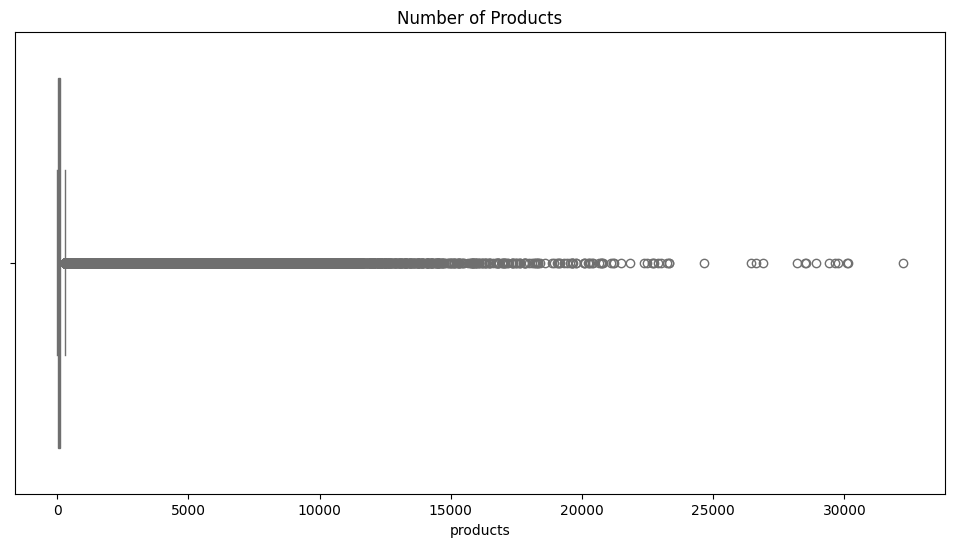

In [ ]:
# User.product boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=user_df['products'], color="skyblue")
plt.title('Number of Products')
plt.show()

In [ ]:
min_product_threshold, max_product_threshold = thresholds(user_df, 'products')

-133.0 ,  283.0


In [ ]:
# Threshold filtering
def threshold_filtering(dataframe, column_name : str, min_threshold: float, max_threshold : float):
    clean_dataframe = dataframe[
        (dataframe[column_name] > min_threshold) &
        (dataframe[column_name] <= max_threshold)
    ]

    print("Before threshold filter : ", dataframe.shape)
    print("After threshold filter : ", clean_dataframe.shape)
    return clean_dataframe

In [ ]:
# Fitler based on min max product thresholds
# Minimum of 1 product and maximum of max_product_threshold products owned
clean_user_product_df = threshold_filtering(
    user_df, 'products', min_threshold = 0, max_threshold = max_product_threshold
)

Before threshold filter :  (14306064, 3)
After threshold filter :  (12909300, 3)


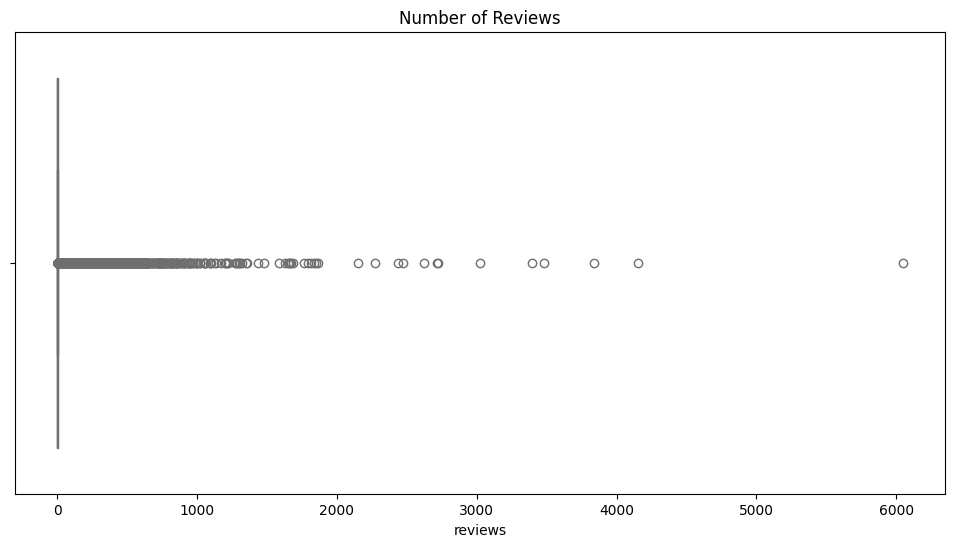

In [ ]:
# User.review boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x = user_df['reviews'], color = "skyblue")
plt.title('Number of Reviews')
plt.show()

In [ ]:
# Filter for reviews as well
# Thresholds for number of reviews
min_review_threshold, max_review_threshold = thresholds(
    clean_user_product_df, 'reviews', moderate_outlier = False
)

# Minimum of 1 review and maximum reviews of max_review_threshold made by users
clean_user_df = threshold_filtering(
    clean_user_product_df, 'reviews', min_threshold = 0, max_threshold = max_review_threshold
)

-2.0 ,  5.0
Before threshold filter :  (12909300, 3)
After threshold filter :  (11336988, 3)


**Recommened dataset**

In [ ]:
recommend_df.hours.describe()

,hours
count,41154794.00
mean,100.60
std,176.17
min,0.00
25%,7.80
50%,27.30
75%,99.20
max,1000.00


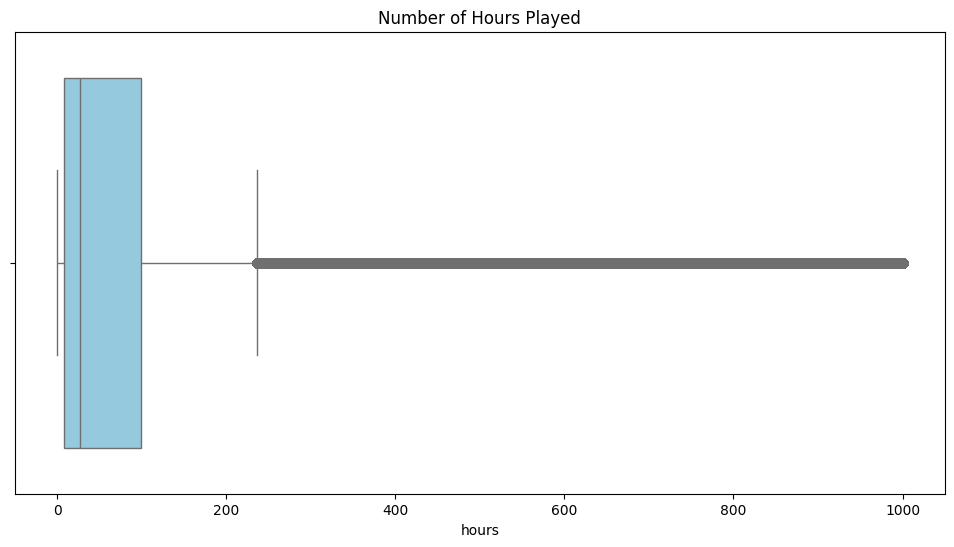

In [ ]:
# Recommend.hours boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x = recommend_df.hours, color = "skyblue")
plt.title('Number of Hours Played')
plt.show()

In [ ]:
# Thresholds for hours played
min_hours_played_threshold, max_hours_played_threshold = thresholds(
    recommend_df, 'hours', moderate_outlier = True
)

# Min hours played of 3 hours and maximum hours played of max_hours_played_threshold hours
clean_recommend_df = threshold_filtering(
    recommend_df, 'hours', min_threshold = 3, max_threshold = max_hours_played_threshold
)

-129.3 ,  236.3
Before threshold filter :  (41154794, 8)
After threshold filter :  (30614240, 8)


**Final recommended dataset**

In [ ]:
# Filter final recommendation dataset based on filtered games and users from clean_game_df & clean_user_df
clean_recommendations = clean_recommend_df[
    (clean_recommend_df['app_id'].isin(clean_game_df['app_id'])) &
    (clean_recommend_df['user_id'].isin(clean_user_df['user_id']))
]

print('Recommendation Dataset before filtering : ', clean_recommend_df.shape)
print('Recommendation Dataset after filtering : ', clean_recommendations.shape)

Recommendation Dataset before filtering :  (30614240, 8)
Recommendation Dataset after filtering :  (13798007, 8)


In [ ]:
clean_recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.30,51580,0
1,304390,4,0,2017-02-17,False,11.50,2586,1
3,703080,0,0,2022-09-23,True,27.40,259432,3
4,526870,0,0,2021-01-10,True,7.90,23869,4
5,306130,0,0,2021-10-10,True,8.60,45425,5


**Game metadata dataset**

In [ ]:
games_metadata_df.describe()

,app_id
count,50872.00
mean,1055223.81
std,610324.95
min,10.00
25%,528737.50
50%,986085.00
75%,1524895.00
max,2599300.00


In [ ]:
# Filter game metadata based on filtered out games
clean_games_metadata_df = games_metadata_df[
    games_metadata_df['app_id'].isin(clean_game_df['app_id'])
]

print("Game Metadata dataset before filtering : ", games_metadata_df.shape)
print("Game Metadata dataset after filtering : ", clean_games_metadata_df.shape)

Game Metadata dataset before filtering :  (50872, 3)
Game Metadata dataset after filtering :  (43405, 3)


In [ ]:
games_metadata_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


# Content-based Filtering

In [ ]:
# Connect items by the description and tags from game_metadata
games_with_info = pd.merge(
    clean_game_df, clean_games_metadata_df, on = 'app_id', how = 'inner'
)
games_with_info.head()

# --- Start of code to sample data ---
# Sample a smaller subset of the data to manage memory
# Adjust the frac parameter to control the size of the subset (e.g., 0.01 for 1%)
sample_fraction = 0.05
sampled_games_with_info = games_with_info.sample(frac=sample_fraction, random_state=42) # Added random_state for reproducibility

print(f"\nOriginal games_with_info shape: {games_with_info.shape}")
games_with_info = sampled_games_with_info # Replace the original dataframe with the sampled one
print(f"Sampled games_with_info shape: {games_with_info.shape}")
# --- End of code to sample data ---


Original games_with_info shape: (43405, 15)
Sampled games_with_info shape: (2170, 15)


In [ ]:
# Create a TF-IDF Vectorizer for the 'description' column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(games_with_info['description'].fillna(''))

print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (2170, 8759)


In [ ]:
def vocab_check(sample_indices: list):
    """
    Checks and displays the top 5 most important words (vocabs) and their TF-IDF scores
    for the given game sample indices.

    Args:
        sample_indices (list): A list of indices of the games to check.
    """
    feature_names = tfidf.get_feature_names_out()

    for index in sample_indices:
        print(f"\nTop 5 vocabs for game at index {index} ({games_with_info.iloc[index]['title']}):")
        # Get the TF-IDF scores for the current game
        tfidf_scores = tfidf_matrix[index].toarray()[0]

        # Get the indices of the top 5 scores
        top_indices = tfidf_scores.argsort()[-5:][::-1]

        # Print the top 5 words and their scores
        for i in top_indices:
            print(f"- {feature_names[i]}: {tfidf_scores[i]:.4f}")

# Example usage:
sample_indices = [5, 10, 15]
vocab_check(sample_indices)


Top 5 vocabs for game at index 5 (江山如画):
- despondent: 0.2916
- contributions: 0.2916
- dominated: 0.2916
- fled: 0.2916
- promotion: 0.2916

Top 5 vocabs for game at index 10 (Aria):
- aria: 0.5807
- half: 0.3427
- intrude: 0.1936
- begun: 0.1936
- kiwi: 0.1936

Top 5 vocabs for game at index 15 (Ghost Song):
- long: 0.2837
- desolate: 0.2198
- lorian: 0.2198
- deadsuit: 0.2198
- slumber: 0.2086


In [ ]:
mlb = MultiLabelBinarizer()
tags_matrix = mlb.fit_transform(games_with_info['tags'])

print("Shape of tags matrix:", tags_matrix.shape)

Shape of tags matrix: (2170, 418)


In [ ]:
# Checking tag matrix of some game samples
n_samples = 3
sample_games = games_with_info.sample(n_samples)

for i in range(n_samples):
    # App id of respective game samples
    app_id = sample_games.iloc[i]['app_id']
    print("\n\nTags For Game = ", sample_games.iloc[i]['title'])
    print("-" * 50)

    # Index of game in sample_games based on games_with_info
    game_index = games_with_info[
        games_with_info['app_id'] == app_id
    ].index[0]

    # Tags from tags matrix
    unique_tags = mlb.classes_
    # Convert matrix to dataframe
    tags_df = pd.DataFrame(tags_matrix, columns = unique_tags, index=games_with_info['app_id'])

    game_tags = tags_df.loc[app_id]
    filtered_tags = game_tags[game_tags == 1]
    filtered_tag_df = pd.DataFrame(filtered_tags).T
    display(filtered_tag_df)



Tags For Game =  The Signifier Director's Cut
--------------------------------------------------


,Adventure,Atmospheric,Choices Matter,Dark,Emotional,Exploration,First-Person,Indie,Investigation,Multiple Endings,Mystery,Nudity,Psychological,Psychological Horror,Sexual Content,Singleplayer,Story Rich,Surreal,Thriller,Walking Simulator
1082930,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




Tags For Game =  Train Simulator: Union Pacific No. 119 Steam Loco Add-On
--------------------------------------------------


,Simulation
678005,1




Tags For Game =  Noel the Mortal Fate Season Final Part 1
--------------------------------------------------


,Action,Adventure,Casual,Indie,RPG,Simulation
2394050,1,1,1,1,1,1


In [ ]:
# Combine matrix
combined_matrix = hstack(
    (tfidf_matrix, tags_matrix)
).astype('float32') # tags_matrix consists of binary values (0, 1) hence conversion to float

print("Dimension of combined_matrix : ", combined_matrix.shape)
print("Combined Matrix data type : ", combined_matrix.dtype)
print("Number of non-zero values : ", combined_matrix.nnz)

total_elements = combined_matrix.shape[0] * combined_matrix.shape[1] # (row * column)
nnz_percentage = (combined_matrix.nnz / total_elements) * 100

print("Percentage of non-zero values in combined_matrix (%) : ", nnz_percentage)

combined_cosine_sim_matrix = cosine_similarity(combined_matrix, combined_matrix)
print("Dimension of combined cosine-similarity matrix : ", combined_cosine_sim_matrix.shape)

Dimension of combined_matrix :  (2170, 9177)
Combined Matrix data type :  float32
Number of non-zero values :  58963
Percentage of non-zero values in combined_matrix (%) :  0.2960868410256256
Dimension of combined cosine-similarity matrix :  (2170, 2170)


In [ ]:
import pickle
import os
from google.colab import drive

# Mount Google Drive
drive_path = '/content/drive'
if not os.path.exists(drive_path):
    drive.mount(drive_path)
else:
    print("Google Drive is already mounted.")

# Define the target directory
save_directory = '/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Content-based'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the combined cosine similarity matrix
with open(os.path.join(save_directory, 'combined_cosine_sim_matrix.pkl'), 'wb') as f:
    pickle.dump(combined_cosine_sim_matrix, f)

# Save the games_with_info dataframe (which is currently the sampled version)
with open(os.path.join(save_directory, 'games_with_info.pkl'), 'wb') as f:
    pickle.dump(games_with_info, f)

print(f"Combined cosine similarity matrix and sampled games_with_info dataframe have been saved to {save_directory}.")

Google Drive is already mounted.
Combined cosine similarity matrix and sampled games_with_info dataframe have been saved to /content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Content-based.


# Collaborative Filtering

In [ ]:
# Merge game and recommendation data
# Using the cleaned dataframes
merged_data = clean_game_df.merge(clean_recommendations, on='app_id')

# Drop unnecessary columns
merged_data.drop(columns=['helpful', 'funny','date', 'hours', 'review_id', 'win', 'mac', 'linux', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck'], inplace=True)

print("Merged data columns after dropping:")
print(merged_data.columns)

print("\nSample from merged data:")
display(merged_data.sample(5))

Merged data columns after dropping:
Index(['app_id', 'title', 'is_recommended', 'user_id'], dtype='object')

Sample from merged data:


,app_id,title,is_recommended,user_id
4413765,238960,Path of Exile,True,9379451
4576445,108600,Project Zomboid,True,3378873
6196441,380600,Fishing Planet,False,7709669
8270001,70,Half-Life,True,7624935
8229536,12210,Grand Theft Auto IV: The Complete Edition,True,13023543


In [ ]:
# Calculate user and game counts from the merged data
user_counts_merged = merged_data['user_id'].value_counts()
game_counts_merged = merged_data['title'].value_counts()

print("User counts from merged data:")
display(user_counts_merged.head())

print("\nGame counts from merged data:")
display(game_counts_merged.head())

print(f"\nNumber of unique users in merged data: {len(user_counts_merged)}")
print(f"Number of unique games in merged data: {len(game_counts_merged)}")

# Filtering based on user and game counts
filtered_users_merged = user_counts_merged[user_counts_merged > 5].index
filtered_games_merged = game_counts_merged[game_counts_merged > 10].index

final_collaborative_df_merged = merged_data[
    (merged_data['user_id'].isin(filtered_users_merged)) &
    (merged_data['title'].isin(filtered_games_merged))
]

print(f"\nShape after filtering merged data (user count > 5, game count > 10): {final_collaborative_df_merged.shape}")

User counts from merged data:


,count
user_id,
7557217,5
12740893,5
2101242,5
4595780,5
10559900,5



Game counts from merged data:


,count
title,
Paladins®,102179
Wallpaper Engine,100238
Cyberpunk 2077,98600
Among Us,93243
Euro Truck Simulator 2,92388



Number of unique users in merged data: 9036964
Number of unique games in merged data: 23471

Shape after filtering merged data (user count > 5, game count > 10): (0, 4)


In [ ]:
merged_data = clean_game_df.merge(clean_recommendations, on='app_id')

In [ ]:
merged_data

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,helpful,funny,date,is_recommended,hours,user_id,review_id
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,13,0,2022-08-11,True,10.80,4177110,14254726
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,0,0,2022-02-04,True,12.40,3108709,14254769
2,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,4,0,2018-04-23,True,20.40,9716984,14254971
3,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,21,3,2020-05-18,True,3.70,12549760,14255060
4,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,0,0,2022-09-06,False,13.70,4645169,14255273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13798002,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,2,0,2022-06-16,True,17.00,13147607,38550394
13798003,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,0,0,2022-06-19,True,6.00,13871385,38571899
13798004,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,0,0,2022-12-26,True,20.00,13899247,40935115
13798005,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,0,0,2022-06-30,True,8.00,7867139,40991222


In [ ]:
merged_data.columns

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck', 'helpful', 'funny', 'date', 'is_recommended',
       'hours', 'user_id', 'review_id'],
      dtype='object')

In [ ]:
merged_data.drop(columns=['helpful', 'funny','date', 'hours', 'review_id'], inplace=True)

In [ ]:
merged_data.sample(1)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,is_recommended,user_id
521966,466560,Northgard,2018-03-07,True,True,True,Very Positive,88,43461,30.00,0.00,0.00,True,True,11876899


In [ ]:
user_count= merged_data['user_id'].value_counts()

In [ ]:
user_count

,count
user_id,
7557217,5
12740893,5
2101242,5
4595780,5
10559900,5
...,...
311125,1
13751604,1
3734786,1


In [ ]:
game_count= merged_data['title'].value_counts()

In [ ]:
game_count

,count
title,
Paladins®,102179
Wallpaper Engine,100238
Cyberpunk 2077,98600
Among Us,93243
Euro Truck Simulator 2,92388
...,...
Harolds Harem: The Neckoning,1
CursorFX,1
Quintaesencia,1


In [ ]:
len(user_count)

9036964

In [ ]:
len(game_count)

23471

In [ ]:
filtered_data= merged_data[merged_data['user_id'].isin(user_count[user_count >=5].index) &
merged_data['title'].isin(game_count[game_count >=20].index)]

In [ ]:
filtered_data

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,is_recommended,user_id
57,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,True,7796918
65,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,True,10631576
101,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,True,11890223
119,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,True,6164281
131,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,True,12112822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13797936,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,True,3616140
13797945,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,False,383928
13797952,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,True,4657944
13797956,1361510,Teenage Mutant Ninja Turtles: Shredder's Revenge,2022-06-16,True,False,True,Very Positive,94,10250,17.00,0.00,0.00,True,True,822187


In [ ]:
# Calculate sparsity level
n_interactions = len(filtered_data)
n_users = filtered_data['user_id'].nunique()
n_games = filtered_data['title'].nunique()

total_possible_interactions = n_users * n_games

# Avoid division by zero if either n_users or n_games is zero
if total_possible_interactions > 0:
    sparsity = 1 - (n_interactions / total_possible_interactions)
    print(f"Number of interactions: {n_interactions}")
    print(f"Number of unique users: {n_users}")
    print(f"Number of unique games: {n_games}")
    print(f"Total possible interactions: {total_possible_interactions}")
    print(f"Sparsity level: {sparsity:.4f}")
else:
    print("Cannot calculate sparsity: Number of unique users or games is zero.")

Number of interactions: 537509
Number of unique users: 108137
Number of unique games: 7911
Total possible interactions: 855471807
Sparsity level: 0.9994


In [ ]:
from scipy.sparse import csr_matrix

# Create a sparse user-item matrix from filtered_data
# Ensure 'user_id' and 'app_id' are treated as categories for better memory usage
filtered_data['user_id'] = filtered_data['user_id'].astype('category')
filtered_data['app_id'] = filtered_data['app_id'].astype('category')

# Create the sparse matrix
sparse_user_item_matrix = csr_matrix((
    filtered_data['is_recommended'].astype(int), # Using 1 for recommended, 0 for not recommended
    (filtered_data['user_id'].cat.codes, filtered_data['app_id'].cat.codes)
))

print("Shape of Sparse User-Item Matrix:", sparse_user_item_matrix.shape)
print("Data type of Sparse User-Item Matrix:", sparse_user_item_matrix.dtype)
print("Number of non-zero values in Sparse User-Item Matrix:", sparse_user_item_matrix.nnz)

# Apply Truncated SVD
from sklearn.decomposition import TruncatedSVD

# Choose the number of components (latent factors) - this is a hyperparameter you can tune
n_components = 50

svd = TruncatedSVD(n_components=n_components, random_state=42)
user_latent_factors = svd.fit_transform(sparse_user_item_matrix)
game_latent_factors = svd.components_.T # Transpose to get game factors

print(f"\nShape of User Latent Factors ({n_components} components):", user_latent_factors.shape)
print(f"Shape of Game Latent Factors ({n_components} components):", game_latent_factors.shape)

Shape of Sparse User-Item Matrix: (108137, 7912)
Data type of Sparse User-Item Matrix: int64
Number of non-zero values in Sparse User-Item Matrix: 537508

Shape of User Latent Factors (50 components): (108137, 50)
Shape of Game Latent Factors (50 components): (7912, 50)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate item-item similarity based on game latent factors
item_similarity_matrix = cosine_similarity(game_latent_factors)

print("Shape of Item Similarity Matrix:", item_similarity_matrix.shape)

Shape of Item Similarity Matrix: (7912, 7912)


In [ ]:
def get_item_based_recommendations(game_title, item_similarity_matrix, data, n_recommendations=10):
    """
    Generates item-based recommendations for a given game.

    Args:
        game_title (str): The title of the game to get recommendations for.
        item_similarity_matrix (np.ndarray): The precomputed item-item similarity matrix.
        data (pd.DataFrame): The dataframe containing game titles and their original indices or app_ids.
        n_recommendations (int): The number of recommendations to return.

    Returns:
        list: A list of recommended game titles.
    """
    # Get the index of the game that matches the title
    try:
        # We need the index corresponding to the item_similarity_matrix.
        # The indices in item_similarity_matrix correspond to the categories created from filtered_data['app_id'].cat.codes
        game_idx_in_filtered = data[data['title'] == game_title]['app_id'].cat.codes.iloc[0]
    except IndexError:
        return f"Game '{game_title}' not found in the filtered data."

    # Get the similarity scores for this game with all other games
    similarity_scores = list(enumerate(item_similarity_matrix[game_idx_in_filtered]))

    # Sort the games based on the similarity scores
    sorted_similar_games = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar games (exclude the game itself)
    top_similar_games = [game for game in sorted_similar_games if game[0] != game_idx_in_filtered][:n_recommendations]

    # Get the game titles of the recommended games
    # Map the category codes back to app_ids to get titles from the original filtered data
    app_id_map = dict(enumerate(data['app_id'].cat.categories))
    recommended_games_titles = [data[data['app_id'] == app_id_map[idx]]['title'].iloc[0] for idx, score in top_similar_games]


    return recommended_games_titles

# Example usage:
# You need to replace 'Your Game Title Here' with an actual game title from your filtered_data['title']
# For example:
game_to_recommend = 'Paladins®' # Replace with a game title present in filtered_data
recommendations = get_item_based_recommendations(game_to_recommend, item_similarity_matrix, filtered_data)

print(f"Recommendations for '{game_to_recommend}':")
for rec in recommendations:
    print(f"- {rec}")

Recommendations for 'Paladins®':
- Shovel Knight Dig
- Batora: Lost Haven
- Dwarfs - F2P
- SC2VN - The eSports Visual Novel
- The Signal From Tölva
- World War II: Panzer Claws
- Who Wants To Be A Millionaire
- Unity of Command: Stalingrad Campaign
- Summoners War: Chronicles
- Tap Adventure: Time Travel


In [ ]:
import pickle
import os
from google.colab import drive

# Define the target directory
save_directory_collaborative = '/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Collaborative'

# Create the directory if it doesn't exist
os.makedirs(save_directory_collaborative, exist_ok=True)

# Save the user latent factors
with open(os.path.join(save_directory_collaborative, 'user_latent_factors.pkl'), 'wb') as f:
    pickle.dump(user_latent_factors, f)

# Save the game latent factors
with open(os.path.join(save_directory_collaborative, 'game_latent_factors.pkl'), 'wb') as f:
    pickle.dump(game_latent_factors, f)

# Save the item similarity matrix
with open(os.path.join(save_directory_collaborative, 'item_similarity_matrix.pkl'), 'wb') as f:
    pickle.dump(item_similarity_matrix, f)

# Save the filtered_data dataframe (contains mappings and data used)
with open(os.path.join(save_directory_collaborative, 'filtered_data.pkl'), 'wb') as f:
    pickle.dump(filtered_data, f)

print(f"Collaborative filtering artifacts have been saved to {save_directory_collaborative}.")

Collaborative filtering artifacts have been saved to /content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Collaborative.


# Hybrid Filtering (can switch filtering)

**Find Path & load files for filtering**

In [ ]:
import pickle
import os

# Define the directory paths
content_based_save_directory = '/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Content-based'
collaborative_save_directory = '/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Collaborative'

In [ ]:
# Load the combined cosine similarity matrix
with open(os.path.join(content_based_save_directory, 'combined_cosine_sim_matrix.pkl'), 'rb') as f:
    loaded_combined_cosine_sim_matrix = pickle.load(f)

# Load the user latent factors
with open(os.path.join(collaborative_save_directory, 'user_latent_factors.pkl'), 'rb') as f:
    loaded_user_latent_factors = pickle.load(f)

# Load the game latent factors
with open(os.path.join(collaborative_save_directory, 'game_latent_factors.pkl'), 'rb') as f:
    loaded_game_latent_factors = pickle.load(f)

# Load the item similarity matrix
with open(os.path.join(collaborative_save_directory, 'item_similarity_matrix.pkl'), 'rb') as f:
    loaded_item_similarity_matrix = pickle.load(f)

In [ ]:
print("Shape of loaded combined cosine similarity matrix:", loaded_combined_cosine_sim_matrix.shape)
print("Shape of loaded user latent factors:", loaded_user_latent_factors.shape)
print("Shape of loaded game latent factors:", loaded_game_latent_factors.shape)
print("Shape of loaded item similarity matrix:", loaded_item_similarity_matrix.shape)

Shape of loaded combined cosine similarity matrix: (2170, 2170)
Shape of loaded user latent factors: (108137, 50)
Shape of loaded game latent factors: (7912, 50)
Shape of loaded item similarity matrix: (7912, 7912)


In [ ]:
import pickle
import os

content_based_save_directory = '/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Content-based'
collaborative_save_directory = '/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Collaborative'

# Load the games_with_info dataframe from content-based filtering
with open(os.path.join(content_based_save_directory, 'games_with_info.pkl'), 'rb') as f:
    loaded_games_with_info_df = pickle.load(f)

# Load the filtered_data dataframe from collaborative filtering
with open(os.path.join(collaborative_save_directory, 'filtered_data.pkl'), 'rb') as f:
    loaded_filtered_data_df = pickle.load(f)

# Print the shapes to confirm
print("Shape of loaded_games_with_info_df:", loaded_games_with_info_df.shape)
print("Shape of loaded_filtered_data_df:", loaded_filtered_data_df.shape)

Shape of loaded_games_with_info_df: (2170, 15)
Shape of loaded_filtered_data_df: (537509, 15)


**Recommendation for content filtering**

In [ ]:
def recommend_based_on_content(game_title, cosine_sim_matrix, games_df, n_recommendations=10):
    """
    Generates content-based recommendations for a given game.

    Args:
        game_title (str): The title of the game to get recommendations for.
        cosine_sim_matrix (np.ndarray): The precomputed content-based cosine similarity matrix.
        games_df (pd.DataFrame): The dataframe containing game titles and their indices (should be the sampled dataframe used for the matrix).
        n_recommendations (int): The number of recommendations to return.

    Returns:
        list: A list of recommended game titles, or an error message if the game is not found.
    """
    # Find the index of the game that matches the title in the sampled dataframe
    try:
        # Use .loc to get the row and then .index[0] to get the index in the current dataframe
        game_index = games_df.index[games_df['title'] == game_title][0]
        # Now find the position of this index in the dataframe's index list
        game_position = games_df.index.get_loc(game_index)

    except IndexError:
        return f"Game '{game_title}' not found in the games data for content-based filtering."

    # Get the similarity scores for this game with all other games
    similarity_scores = list(enumerate(cosine_sim_matrix[game_position]))

    # Sort the games based on the similarity scores
    sorted_similar_games = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar games (exclude the game itself)
    top_similar_games = [game for game in sorted_similar_games if game[0] != game_position][:n_recommendations]

    # Get the game titles of the recommended games
    recommended_games_titles = [games_df.iloc[idx]['title'] for idx, score in top_similar_games]

    return recommended_games_titles

# Example usage (using loaded_games_with_info_df and loaded_combined_cosine_sim_matrix)
# Find a valid game title from loaded_games_with_info_df
example_game_title_valid = loaded_games_with_info_df['title'].sample(1).iloc[0]
print(f"Using '{example_game_title_valid}' as an example game title.")

# Use the valid example game title to get recommendations
content_recommendations = recommend_based_on_content(
    example_game_title_valid,
    loaded_combined_cosine_sim_matrix,
    loaded_games_with_info_df # Pass the sampled dataframe
)

print(f"\nContent-based recommendations for '{example_game_title_valid}':")
if isinstance(content_recommendations, list):
    for rec in content_recommendations:
        print(f"- {rec}")
else:
    print(content_recommendations) # Print error message if game not found

Using 'Super Time Force Ultra' as an example game title.

Content-based recommendations for 'Super Time Force Ultra':
- Bot Vice
- Operation Hardcore
- Aqua Kitty - Milk Mine Defender
- Romino's Adventure
- Rusty Gun
- Monster Knockout
- Guns N' Runs
- Unwell Known
- Billy 101
- Puzzle Box


**Recommendation for collaborative filtering**

In [ ]:
def recommend_based_on_collaborative(game_title, item_similarity_matrix, data, n_recommendations=10):
    """
    Generates item-based recommendations using collaborative filtering artifacts.

    Args:
        game_title (str): The title of the game to get recommendations for.
        item_similarity_matrix (np.ndarray): The precomputed item-item similarity matrix
                                              from collaborative filtering (based on latent factors).
        data (pd.DataFrame): The dataframe containing game titles and their app_ids,
                             used to create the sparse matrix (e.g., filtered_data).
        n_recommendations (int): The number of recommendations to return.

    Returns:
        list: A list of recommended game titles, or an error message if the game is not found.
    """
    # Find the index of the game that matches the title in the data used for collaborative filtering
    try:
        # We need the index corresponding to the item_similarity_matrix.
        # The indices in item_similarity_matrix correspond to the categories created from data['app_id'].cat.codes
        game_idx_in_filtered = data[data['title'] == game_title]['app_id'].cat.codes.iloc[0]
    except IndexError:
        return f"Game '{game_title}' not found in the filtered data for collaborative filtering."

    # Get the similarity scores for this game with all other games from the collaborative item similarity matrix
    similarity_scores = list(enumerate(item_similarity_matrix[game_idx_in_filtered]))

    # Sort the games based on the similarity scores
    sorted_similar_games = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar games (exclude the game itself)
    top_similar_games = [game for game in sorted_similar_games if game[0] != game_idx_in_filtered][:n_recommendations]

    # Get the game titles of the recommended games
    # Map the category codes back to app_ids to get titles from the original filtered data
    app_id_map = dict(enumerate(data['app_id'].cat.categories))
    recommended_games_titles = [data[data['app_id'] == app_id_map[idx]]['title'].iloc[0] for idx, score in top_similar_games]

    return recommended_games_titles

# Example usage (requires loaded_item_similarity_matrix and loaded_filtered_data_df)
# Assuming loaded_item_similarity_matrix and loaded_filtered_data_df are available
# You need a game title that exists in loaded_filtered_data_df
if not loaded_filtered_data_df.empty:
    # Get a sample game title from the filtered data for collaborative filtering
    example_game_title_collab = loaded_filtered_data_df['title'].sample(1).iloc[0]
    print(f"Using '{example_game_title_collab}' as an example game title for collaborative filtering.")

    collab_recommendations = recommend_based_on_collaborative(
        example_game_title_collab,
        loaded_item_similarity_matrix,
        loaded_filtered_data_df # Pass the filtered data dataframe
    )

    print(f"\nCollaborative recommendations for '{example_game_title_collab}':")
    if isinstance(collab_recommendations, list):
        for rec in collab_recommendations:
            print(f"- {rec}")
    else:
        print(collab_recommendations) # Print error message if game not found
else:
     print("loaded_filtered_data_df is empty, cannot generate example collaborative recommendations.")

Using 'Peggle Deluxe' as an example game title for collaborative filtering.

Collaborative recommendations for 'Peggle Deluxe':
- Clustertruck
- Super Auto Pets
- Quaver
- Monster Prom 3: Monster Roadtrip
- KovaaK's
- Bloons Adventure Time TD
- Crush Crush
- Bloons TD Battles 2
- Cookie Clicker
- GUILTY GEAR Xrd REV 2


**Recommendation for hybrid filtering**

In [ ]:
def recommend_hybrid(game_title, n_recommendations=10, content_weight=0.5, collaborative_weight=0.5):
    """
    Generates hybrid recommendations for a given game by combining content-based
    and collaborative filtering results.

    Args:
        game_title (str): The title of the game to get recommendations for.
        n_recommendations (int): The total number of recommendations to return.
        content_weight (float): Weight for content-based recommendations (between 0 and 1).
        collaborative_weight (float): Weight for collaborative filtering recommendations (between 0 and 1).

    Returns:
        list: A list of unique recommended game titles, limited to n_recommendations,
              or an error message if the game is not found in either dataset.
    """
    # Ensure weights sum to 1 (optional, but good practice)
    total_weight = content_weight + collaborative_weight
    if total_weight != 1.0 and total_weight != 0:
        content_weight /= total_weight
        collaborative_weight /= total_weight
    elif total_weight == 0:
        # Handle case where both weights are 0, perhaps default to equal weights
        content_weight = 0.5
        collaborative_weight = 0.5

    # Get content-based recommendations
    content_recs = recommend_based_on_content(
        game_title,
        loaded_combined_cosine_sim_matrix,
        loaded_games_with_info_df,
        n_recommendations=int(n_recommendations * content_weight * 2) # Get more from each to allow for combination and removal of duplicates
    )

    # Get collaborative filtering recommendations
    collaborative_recs = recommend_based_on_collaborative(
        game_title,
        loaded_item_similarity_matrix,
        loaded_filtered_data_df,
        n_recommendations=int(n_recommendations * collaborative_weight * 2) # Get more from each
    )

    # Handle cases where the game is not found in one or both datasets
    game_found_content = isinstance(content_recs, list)
    game_found_collaborative = isinstance(collaborative_recs, list)

    if not game_found_content and not game_found_collaborative:
        # Game not found in either dataset
        return f"Game '{game_title}' not found in either content-based or collaborative filtering datasets."
    elif not game_found_content:
        # Game found only in collaborative dataset
        print(f"Warning: Game '{game_title}' not found in content-based data. Using only collaborative recommendations.")
        combined_recommendations = collaborative_recs
    elif not game_found_collaborative:
        # Game found only in content-based dataset
        print(f"Warning: Game '{game_title}' not found in collaborative data. Using only content-based recommendations.")
        combined_recommendations = content_recs
    else:
        # Game found in both, combine recommendations
        # Simple combination: alternate recommendations and remove duplicates
        combined_recommendations = []
        max_len = max(len(content_recs), len(collaborative_recs))
        for i in range(max_len):
            if i < len(content_recs):
                combined_recommendations.append(content_recs[i])
            if i < len(collaborative_recs):
                combined_recommendations.append(collaborative_recs[i])

    # Remove duplicates while preserving order as much as possible
    seen_titles = set()
    unique_recommendations = []
    for title in combined_recommendations:
        if title not in seen_titles and title != game_title:
            unique_recommendations.append(title)
            seen_titles.add(title)

    # Return the top N unique recommendations
    return unique_recommendations[:n_recommendations]

# Example usage:
# You need to choose a game title that exists in at least one of the loaded dataframes
example_game_title_hybrid = 'Paladins®' # This game exists in both filtered_data and sampled games_with_info

hybrid_recommendations = recommend_hybrid(example_game_title_hybrid, n_recommendations=15)

print(f"\nHybrid recommendations for '{example_game_title_hybrid}':")
if isinstance(hybrid_recommendations, list):
    if hybrid_recommendations:
        for rec in hybrid_recommendations:
            print(f"- {rec}")
    else:
        print("No hybrid recommendations found.")
else:
    print(hybrid_recommendations) # Print error message if game not found


Hybrid recommendations for 'Paladins®':
- The Signal From Tölva
- The Swords of Ditto: Mormo's Curse
- Who Wants To Be A Millionaire
- Shovel Knight Dig
- Dwarfs - F2P
- Spooky Station
- Summoners War: Chronicles
- Live Wallpaper Master
- Unity of Command: Stalingrad Campaign
- Spike Volleyball
- Batora: Lost Haven
- Castlevania: Lords of Shadow – Mirror of Fate HD
- World War II: Panzer Claws
- SC2VN - The eSports Visual Novel
- Tap Adventure: Time Travel


In [ ]:
# Choose a game title that is likely to be in both loaded_games_with_info_df (sampled) and loaded_filtered_data_df
# Let's pick a popular game title that was present in the initial head() calls
example_game_title_hybrid_test = 'Paladins®'

# Call the recommend_hybrid function
hybrid_recommendations_test = recommend_hybrid(
    example_game_title_hybrid_test,
    n_recommendations=15 # Request 15 recommendations
)

# Print the hybrid recommendations
print(f"\nHybrid recommendations for '{example_game_title_hybrid_test}':")
if isinstance(hybrid_recommendations_test, list):
    if hybrid_recommendations_test:
        for i, rec in enumerate(hybrid_recommendations_test):
            print(f"{i+1}. {rec}")
    else:
        print("No hybrid recommendations found.")
else:
    print(hybrid_recommendations_test) # Print error message if game not found


Hybrid recommendations for 'Paladins®':
1. The Signal From Tölva
2. The Swords of Ditto: Mormo's Curse
3. Who Wants To Be A Millionaire
4. Shovel Knight Dig
5. Dwarfs - F2P
6. Spooky Station
7. Summoners War: Chronicles
8. Live Wallpaper Master
9. Unity of Command: Stalingrad Campaign
10. Spike Volleyball
11. Batora: Lost Haven
12. Castlevania: Lords of Shadow – Mirror of Fate HD
13. World War II: Panzer Claws
14. SC2VN - The eSports Visual Novel
15. Tap Adventure: Time Travel


## Giải thích các Model Đề xuất

Hệ thống đề xuất lai này sử dụng hai phương pháp lọc chính: **Lọc dựa trên nội dung (Content-based Filtering)** và **Lọc cộng tác (Collaborative Filtering)**.

### 1. Lọc dựa trên Nội dung (Content-based Filtering)

Phương pháp này đề xuất các mục (game) cho người dùng dựa trên sự tương đồng giữa các thuộc tính của mục đó và các mục mà người dùng đã thích trước đây. Trong notebook này, chúng ta sử dụng thông tin mô tả và thẻ (tags) của game để xây dựng mô hình content-based:

*   **TF-IDF Vectorizer:**
    *   **Mục đích:** Chuyển đổi dữ liệu văn bản (mô tả game) thành các vector số. TF-IDF (Term Frequency-Inverse Document Frequency) là một kỹ thuật thống kê đo lường mức độ quan trọng của một từ trong một tài liệu so với một tập hợp tài liệu. Nó giúp giảm bớt tầm quan trọng của các từ phổ biến (như "the", "a", "is") và tăng tầm quan trọng của các từ đặc trưng hơn.
    *   **Cách hoạt động:**
        *   **Term Frequency (TF):** Tần suất xuất hiện của một từ trong một tài liệu.
        *   **Inverse Document Frequency (IDF):** Đo lường mức độ hiếm của một từ trong toàn bộ tập hợp tài liệu.
        *   TF-IDF là tích của TF và IDF.
    *   **Kết quả:** Tạo ra một ma trận (ma trận TF-IDF) trong đó mỗi hàng đại diện cho một game và mỗi cột đại diện cho một từ trong từ vựng, với các giá trị là điểm TF-IDF của từ đó trong game.
*   **MultiLabelBinarizer:**
    *   **Mục đích:** Chuyển đổi danh sách các thẻ (tags) của mỗi game thành một định dạng nhị phân.
    *   **Cách hoạt động:** Tạo ra một ma trận trong đó mỗi hàng đại diện cho một game và mỗi cột đại diện cho một thẻ duy nhất trong toàn bộ tập hợp thẻ. Giá trị là 1 nếu game có thẻ đó và 0 nếu không.
*   **Kết hợp Ma trận (hstack):**
    *   **Mục đích:** Kết hợp ma trận TF-IDF (từ mô tả) và ma trận nhị phân (từ thẻ) thành một ma trận duy nhất. Điều này cho phép chúng ta sử dụng cả hai loại thông tin nội dung để tính toán sự tương đồng giữa các game.
*   **Cosine Similarity:**
    *   **Mục đích:** Đo lường sự tương đồng giữa hai vector bằng cách tính cosine của góc giữa chúng. Giá trị gần 1 cho thấy sự tương đồng cao, giá trị gần 0 cho thấy ít tương đồng.
    *   **Cách hoạt động:** Áp dụng trên ma trận kết hợp để tính toán ma trận tương đồng cosine giữa tất cả các cặp game. Ma trận này cho biết mức độ giống nhau về nội dung giữa bất kỳ hai game nào.
    *   **Kết quả:** Ma trận tương đồng cosine `combined_cosine_sim_matrix`, được sử dụng để tìm các game có nội dung tương tự với game mà người dùng quan tâm.

### 2. Lọc Cộng tác (Collaborative Filtering)

Phương pháp này đề xuất các mục dựa trên hành vi của người dùng, giả định rằng những người dùng có hành vi tương tự trong quá khứ sẽ có sở thích tương tự trong tương lai. Trong notebook này, chúng ta sử dụng dữ liệu đề xuất (recommendations) để xây dựng mô hình item-based collaborative filtering dựa trên phân tích ma trận:

*   **Sparse User-Item Matrix (CSR Matrix):**
    *   **Mục đích:** Biểu diễn dữ liệu tương tác giữa người dùng và game một cách hiệu quả về bộ nhớ. Dữ liệu đề xuất rất thưa (sparse) vì mỗi người dùng chỉ tương tác với một phần nhỏ trong tổng số game. CSR (Compressed Sparse Row) là một định dạng lưu trữ tối ưu cho ma trận thưa.
    *   **Cách hoạt động:** Tạo ra một ma trận trong đó các hàng là người dùng, các cột là game và các giá trị biểu thị tương tác (ví dụ: 1 nếu được đề xuất, 0 nếu không được đề xuất).
*   **Truncated SVD (Singular Value Decomposition):**
    *   **Mục đích:** Giảm chiều (dimensionality reduction) ma trận user-item thưa và phát hiện các yếu tố tiềm ẩn (latent factors) giải thích mối quan hệ giữa người dùng và game. SVD phân rã ma trận user-item thành ba ma trận nhỏ hơn, trong đó hai ma trận chứa các yếu tố tiềm ẩn cho người dùng và game. "Truncated" có nghĩa là chúng ta chỉ giữ lại một số lượng nhỏ các yếu tố tiềm ẩn quan trọng nhất (`n_components`).
    *   **Cách hoạt động:** Áp dụng SVD trên ma trận user-item để tạo ra ma trận yếu tố tiềm ẩn người dùng (`user_latent_factors`) và ma trận yếu tố tiềm ẩn game (`game_latent_factors`). Các hàng trong `game_latent_factors` biểu diễn mỗi game dưới dạng một vector trong không gian các yếu tố tiềm ẩn.
    *   **Kết quả:** `user_latent_factors` và `game_latent_factors` biểu diễn người dùng và game trong một không gian chiều thấp, nơi khoảng cách giữa các vector phản ánh sự tương đồng về sở thích hoặc đặc điểm.
*   **Item Similarity Matrix (từ Game Latent Factors):**
    *   **Mục đích:** Tính toán sự tương đồng giữa các game dựa trên các yếu tố tiềm ẩn của chúng được học từ dữ liệu tương tác của người dùng.
    *   **Cách hoạt động:** Áp dụng Cosine Similarity (hoặc một độ đo tương đồng khác) trên ma trận `game_latent_factors`.
    *   **Kết quả:** Ma trận tương đồng giữa các game `item_similarity_matrix` dựa trên cách người dùng tương tác với chúng. Tệp này được sử dụng bởi hàm đề xuất collaborative để tìm các game có xu hướng được người dùng tương tự đề xuất.

### 3. Lọc Lai (Hybrid Filtering)

Hệ thống lai kết hợp kết quả từ cả hai phương pháp trên. Bằng cách kết hợp các đề xuất từ mô hình content-based (dựa trên thuộc tính game) và mô hình collaborative (dựa trên hành vi người dùng), hệ thống có thể cung cấp các đề xuất đa dạng và chính xác hơn, vượt qua hạn chế của từng phương pháp riêng lẻ (ví dụ: vấn đề "cold-start" trong collaborative filtering hoặc việc bỏ lỡ các mục mới/đặc trưng trong content-based filtering). Trong notebook này, phương pháp lai được thực hiện bằng cách lấy một số lượng đề xuất từ mỗi mô hình và kết hợp chúng, loại bỏ các mục trùng lặp.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Để tính RMSE và MSE, chúng ta cần dự đoán giá trị 'is_recommended' cho các tương tác
# Chúng ta có thể sử dụng tích của user_latent_factors và game_latent_factors để có được ma trận dự đoán
predicted_interactions = np.dot(loaded_user_latent_factors, loaded_game_latent_factors.T)

# Ma trận dự đoán này có kích thước (số_lượng_user_duy_nhất_đã_lọc, số_lượng_game_duy_nhất_đã_lọc)
# Chúng ta cần khớp các dự đoán này với dữ liệu thực tế trong filtered_data_df

# Tạo mapping từ category codes về user_id và app_id
user_id_map = dict(enumerate(loaded_filtered_data_df['user_id'].cat.categories))
app_id_map = dict(enumerate(loaded_filtered_data_df['app_id'].cat.categories))

# Tạo mapping ngược từ user_id và app_id về category codes
user_to_code = {user: code for code, user in user_id_map.items()}
app_to_code = {app: code for code, app in app_id_map.items()}

# Lấy các category codes tương ứng với dữ liệu trong filtered_data_df
actual_user_codes = loaded_filtered_data_df['user_id'].cat.codes
actual_app_codes = loaded_filtered_data_df['app_id'].cat.codes
actual_recommendations = loaded_filtered_data_df['is_recommended'].astype(int)

# Lấy các giá trị dự đoán tương ứng với các tương tác thực tế
predicted_values = predicted_interactions[actual_user_codes, actual_app_codes]

# Chuyển đổi predicted_values thành giá trị nhị phân (0 hoặc 1) để so sánh trực tiếp với actual_recommendations
# Có nhiều cách để làm điều này, ví dụ sử dụng ngưỡng 0.5
binary_predictions = (predicted_values > 0.5).astype(int)


# Tính MSE
mse = mean_squared_error(actual_recommendations, binary_predictions)

# Tính RMSE
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE) for Collaborative Filtering: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) for Collaborative Filtering: {rmse:.4f}")

### Giải thích về cách tính MSE và RMSE cho Collaborative Filtering

1.  **Tái tạo ma trận dự đoán:**
    *   Mô hình Truncated SVD phân rã ma trận người dùng-mục thành hai ma trận yếu tố tiềm ẩn: `user_latent_factors` và `game_latent_factors`.
    *   Tích của hai ma trận này (`user_latent_factors` và chuyển vị của `game_latent_factors`) sẽ tái tạo lại ma trận tương tác dự đoán. Mỗi giá trị trong ma trận này là dự đoán về mức độ tương tác (trong trường hợp này là khả năng được đề xuất) giữa một người dùng cụ thể và một game cụ thể.
2.  **Khớp dự đoán với dữ liệu thực tế:**
    *   Ma trận dự đoán có kích thước tương ứng với số lượng người dùng và game *duy nhất* trong dữ liệu đã lọc (`loaded_filtered_data_df`).
    *   Để tính lỗi, chúng ta chỉ cần xem xét các dự đoán cho những cặp người dùng-game *thực tế* tồn tại trong `loaded_filtered_data_df`.
    *   Chúng ta sử dụng các category codes đã tạo trong quá trình chuẩn bị dữ liệu Collaborative Filtering để lấy các giá trị dự đoán tương ứng với các tương tác thực tế.
3.  **Chuyển đổi dự đoán:**
    *   Giá trị dự đoán từ tích của các yếu tố tiềm ẩn có thể là số thực.
    *   Vì dữ liệu thực tế `is_recommended` là nhị phân (True/False, được chuyển đổi thành 1/0), chúng ta cần chuyển đổi các giá trị dự đoán thành định dạng nhị phân để so sánh trực tiếp. Một cách đơn giản là sử dụng ngưỡng (ví dụ: nếu dự đoán > 0.5 thì coi là 1, ngược lại là 0).
4.  **Tính toán MSE và RMSE:**
    *   Sử dụng hàm `mean_squared_error` từ thư viện `sklearn.metrics` để tính MSE giữa các giá trị `is_recommended` thực tế và các giá trị dự đoán nhị phân.
    *   RMSE là căn bậc hai của MSE.

Các giá trị MSE và RMSE càng thấp thì mô hình càng dự đoán chính xác các tương tác (liệu người dùng có đề xuất game hay không) trong dữ liệu đã lọc.

## Thành phần cần thiết để triển khai hệ thống đề xuất lai (Hybrid Filtering)

Để triển khai và sử dụng hệ thống đề xuất lai, bạn cần tải các tệp sau từ Google Drive:

1.  **`combined_cosine_sim_matrix.pkl`**
    *   **Mô tả:** Ma trận tương đồng cosine được tính toán từ sự kết hợp các đặc trưng mô tả và thẻ (tags) của game (từ phần lọc dựa trên nội dung). Tệp này được sử dụng bởi hàm đề xuất content-based để tìm các game tương tự.
    *   **Đường dẫn:** `/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Content-based/combined_cosine_sim_matrix.pkl`

2.  **`games_with_info.pkl`**
    *   **Mô tả:** Dataframe chứa thông tin chi tiết về các game đã được sử dụng trong content-based filtering (đã lấy mẫu). Nó chứa các cột như `app_id`, `title`, `description`, `tags`,... Dataframe này cần thiết để ánh xạ chỉ mục trong ma trận tương đồng trở lại thông tin game thực tế và để hàm content-based tìm kiếm game theo tên.
    *   **Đường dẫn:** `/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Content-based/games_with_info.pkl`

3.  **`item_similarity_matrix.pkl`**
    *   **Mô tả:** Ma trận tương đồng giữa các game được tính toán từ các yếu tố tiềm ẩn của game sau khi áp dụng SVD trên dữ liệu tương tác (từ phần collaborative filtering). Tệp này được sử dụng bởi hàm đề xuất item-based collaborative filtering.
    *   **Đường dẫn:** `/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Collaborative/item_similarity_matrix.pkl`

4.  **`filtered_data.pkl`**
    *   **Mô tả:** Dataframe chứa dữ liệu tương tác (người dùng, game, trạng thái đề xuất) đã được lọc và sử dụng để xây dựng mô hình collaborative filtering. Dataframe này chứa các ánh xạ giữa `user_id`, `app_id` (dưới dạng category codes) và tiêu đề game, cần thiết để hàm đề xuất collaborative tìm chỉ mục và lấy tên game.
    *   **Đường dẫn:** `/content/drive/Shareddrives/[RCM] - GROUP 5/Final/RCM-model/Collaborative/filtered_data.pkl`

Khi triển khai hệ thống, bạn cần đảm bảo rằng các tệp này được tải thành công vào môi trường chạy của mình và các biến tương ứng (`loaded_combined_cosine_sim_matrix`, `loaded_games_with_info_df`, `loaded_item_similarity_matrix`, `loaded_filtered_data_df`) được gán giá trị trước khi gọi hàm đề xuất lai.